In [29]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [30]:
!pip install keras_cv -q

In [31]:
!pip install --upgrade keras

In [32]:
!pip install segmentation_models

In [33]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import keras
from tensorflow.keras import ops
import keras_cv
import numpy as np
import segmentation_models as sm
from keras_cv.datasets import pascal_voc
from keras_cv.datasets.pascal_voc.segmentation import load as load_voc
from tensorflow.keras import backend as K

In [34]:
!mkdir -p ~/.keras/datasets
!wget -qO- https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/semantic_contours/benchmark.tgz \
  | tar -xz -C ~/.keras/datasets

In [35]:
BASE_DIR = f"{os.path.expanduser('~')}/.keras/datasets"
train_ds = pascal_voc.segmentation.load(split="sbd_train", data_dir=BASE_DIR)
eval_ds  = pascal_voc.segmentation.load(split="sbd_eval",  data_dir=BASE_DIR)

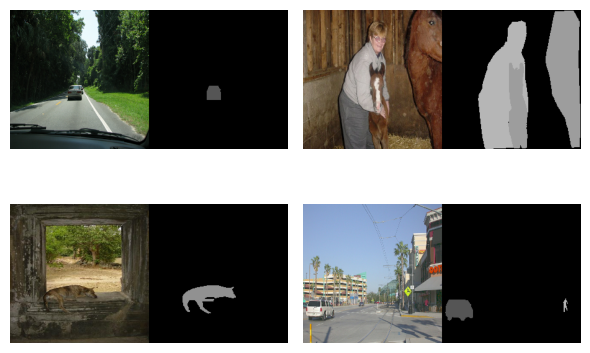

In [36]:
def preprocess_tfds_inputs(inputs):
    def unpackage_tfds_inputs(tfds_inputs):
        return {
            "images": tfds_inputs["image"],
            "segmentation_masks": tfds_inputs["class_segmentation"],
        }

    outputs = inputs.map(unpackage_tfds_inputs)
    outputs = outputs.map(keras_cv.layers.Resizing(height=224, width=224))
    outputs = outputs.batch(32, drop_remainder=True)
    return outputs


train_ds = preprocess_tfds_inputs(train_ds)
batch = train_ds.take(1).get_single_element()
keras_cv.visualization.plot_segmentation_mask_gallery(
    batch["images"],
    value_range=(0, 255),
    num_classes=21,
    y_true=batch["segmentation_masks"],
    scale=3,
    rows=2,
    cols=2,
)

In [37]:
eval_ds = preprocess_tfds_inputs(eval_ds)

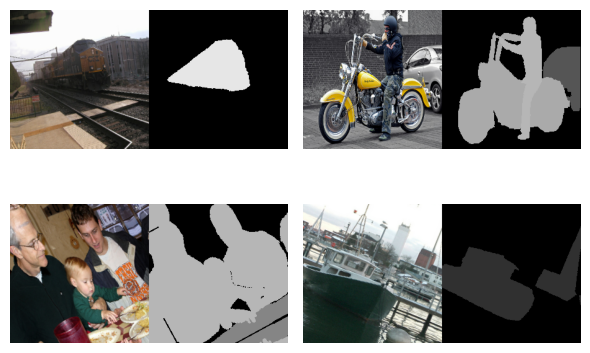

In [38]:
train_ds = train_ds.map(keras_cv.layers.RandomFlip())
train_ds = train_ds.map(keras_cv.layers.RandomRotation(factor=.1,segmentation_classes=21))

batch = train_ds.take(1).get_single_element()

keras_cv.visualization.plot_segmentation_mask_gallery(
    batch["images"],
    value_range=(0, 255),
    num_classes=21,
    y_true=batch["segmentation_masks"],
    scale=3,
    rows=2,
    cols=2,
)

In [39]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.models import Model
def unet_model(input_size=(224,224, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2,2))(c4)

    # Bottleneck
    c5 = Conv2D(512, (3,3), activation='relu', padding='same')(p4)
    c5 = Conv2D(512, (3,3), activation='relu', padding='same')(c5)

    # Decoder
    u8 = Conv2DTranspose(512,(2,2),strides=(2,2),activation='relu',padding='same')(c5)
    u8 = concatenate([c4,u8])
    c8 = Conv2D(512, (3,3), activation='relu', padding='same')(u8)
    c8 = Conv2D(512, (3,3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(256,(2,2),strides=(2,2),activation='relu',padding='same')(c8)
    u9 = concatenate([c3,u9])
    c9 = Conv2D(256, (3,3), activation='relu', padding='same')(u9)
    c9 = Conv2D(256, (3,3), activation='relu', padding='same')(c9)

    u10 = Conv2DTranspose(128,(2,2),strides=(2,2),activation='relu',padding='same')(c9)
    u10 = concatenate([c2,u10])
    c10 = Conv2D(128, (3,3), activation='relu', padding='same')(u10)
    c10 = Conv2D(128, (3,3), activation='relu', padding='same')(c10)


    u11 = Conv2DTranspose(64,(2,2),strides=(2,2),activation='relu',padding='same')(c10)
    u11 = concatenate([c1,u11])
    c11 = Conv2D(64, (3,3), activation='relu', padding='same')(u11)
    c11 = Conv2D(64, (3,3), activation='relu', padding='same')(c11)

    # Outputs
    outputs = Conv2D(21, (1, 1), activation='softmax', padding='same')(c11)



    model = Model(inputs=[inputs], outputs=[outputs])
    return model


model = unet_model()


In [40]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [41]:
def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [42]:
metrics=['accuracy', jaccard_coef]
model.compile(loss=total_loss,optimizer='adam',metrics=metrics)

In [43]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 224, 224,  │      1,792 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 224, 224,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 112, 112,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 112, 112,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 112, 112,  │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 56, 56,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 56, 56,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 56, 56,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 28, 28,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 28, 28,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 28, 28,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 14, 14,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 14, 14,    │  2,359,808 │ max_pooling2d_7[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 14, 14,    │  2,359,808 │ conv2d_27[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 28, 28,    │  1,049,088 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 28, 28,    │          0 │ conv2d_26[0][0],

 Total params: 20,546,261 (78.38 MB)

 Trainable params: 20,546,261 (78.38 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
def dict_to_tuple(x):


    return x["images"], tf.one_hot(
        tf.cast(tf.squeeze(x["segmentation_masks"], axis=-1), "int32"), 21
    )


train_ds = train_ds.map(dict_to_tuple)
eval_ds = eval_ds.map(dict_to_tuple)


In [ ]:
model.fit(train_ds.repeat(), validation_data=eval_ds.repeat(), epochs=10,steps_per_epoch=8498 // 32 , validation_steps=2857//32 )

Epoch 1/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 802s 3s/step - accuracy: 0.6137 - jaccard_coef: 0.3267 - loss: 0.9789 - val_accuracy: 0.6106 - val_jaccard_coef: 0.3413 - val_loss: 0.9453
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 715s 3s/step - accuracy: 0.6278 - jaccard_coef: 0.3705 - loss: 0.9426 - val_accuracy: 0.6135 - val_jaccard_coef: 0.3678 - val_loss: 0.9371
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 682s 3s/step - accuracy: 0.6099 - jaccard_coef: 0.3788 - loss: 0.9338 - val_accuracy: 0.5537 - val_jaccard_coef: 0.3268 - val_loss: 0.9231
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 682s 3s/step - accuracy: 0.6044 - jaccard_coef: 0.3898 - loss: 0.9252 - val_accuracy: 0.5866 - val_jaccard_coef: 0.3955 - val_loss: 0.9290
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 682s 3s/step - accuracy: 0.6024 - jaccard_coef: 0.4009 - loss: 0.9159 - val_accuracy: 0.6358 - val_jaccard_coef: 0.4382 - val_loss: 0.9074
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 682s 3s/step - accuracy: 0.6026 - jaccard_coef: 0.4058 - loss: 0.

In [45]:
activation='softmax'

LR = 0.001
optim = keras.optimizers.Adam(LR)


dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


In [46]:
BACKBONE1 = 'mobilenetv2'

n_classes=21
# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)
model1.compile(optim, total_loss, metrics=metrics)
print(model1.summary())

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_pad           │ (None, None,      │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, None,      │        864 │ Conv1_pad[0][0]   │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, None,      │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, None,      │          0 │ bn_Conv1[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │          0 │ expanded_conv_de… │
│ (ReLU)              │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │        512 │ expanded_conv_de… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, None,      │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, None,      │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, None,      │          0 │ block_1_expand_B… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, None,      │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, None,      │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │          0 │ block_1_depthwis

 Total params: 8,050,341 (30.71 MB)

 Trainable params: 8,014,245 (30.57 MB)

 Non-trainable params: 36,096 (141.00 KB)

None


In [47]:
flag = True
for l in model1.layers:
  if  l.name=='decoder_stage0_upsampling':
    flag = False
  if flag:
    l.trainable = False

In [48]:
model1.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_pad           │ (None, None,      │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, None,      │        864 │ Conv1_pad[0][0]   │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, None,      │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, None,      │          0 │ bn_Conv1[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │          0 │ expanded_conv_de… │
│ (ReLU)              │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │        512 │ expanded_conv_de… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, None,      │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, None,      │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, None,      │          0 │ block_1_expand_B… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, None,      │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, None,      │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │          0 │ block_1_depthwis

 Total params: 8,050,341 (30.71 MB)

 Trainable params: 5,790,373 (22.09 MB)

 Non-trainable params: 2,259,968 (8.62 MB)

In [49]:
model1.fit(train_ds, validation_data=eval_ds, epochs=10, batch_size=32 )

Epoch 1/10
    265/Unknown 488s 2s/step - accuracy: 0.4991 - jaccard_coef: 0.2714 - loss: 0.9463

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


265/265 ━━━━━━━━━━━━━━━━━━━━ 524s 2s/step - accuracy: 0.4995 - jaccard_coef: 0.2717 - loss: 0.9462 - val_accuracy: 0.3370 - val_jaccard_coef: 0.1659 - val_loss: 0.9813
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - accuracy: 0.6644 - jaccard_coef: 0.4336 - loss: 0.8809 - val_accuracy: 0.6263 - val_jaccard_coef: 0.4220 - val_loss: 0.8758
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 519s 2s/step - accuracy: 0.6491 - jaccard_coef: 0.4373 - loss: 0.8621 - val_accuracy: 0.6653 - val_jaccard_coef: 0.4697 - val_loss: 0.8825
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 563s 2s/step - accuracy: 0.6439 - jaccard_coef: 0.4475 - loss: 0.8494 - val_accuracy: 0.5627 - val_jaccard_coef: 0.3700 - val_loss: 0.8509
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 562s 2s/step - accuracy: 0.6555 - jaccard_coef: 0.4649 - loss: 0.8255 - val_accuracy: 0.6600 - val_jaccard_coef: 0.4767 - val_loss: 0.8628
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 560s 2s/step - accuracy: 0.6617 - jaccard_coef: 0.4749 - loss: 0.8176 - val_

In [50]:
for l in model1.layers:
    l.trainable = True

In [51]:
LR = 0.000005
optim = keras.optimizers.Adam(LR)

In [52]:
model1.compile(optim, total_loss, metrics=metrics)

In [53]:
model1.fit(train_ds, validation_data=eval_ds, epochs=5, batch_size=32 )

Epoch 1/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.6584 - jaccard_coef: 0.4779 - loss: 0.8442 - val_accuracy: 0.6685 - val_jaccard_coef: 0.4859 - val_loss: 0.8051
Epoch 2/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 541s 2s/step - accuracy: 0.7126 - jaccard_coef: 0.5378 - loss: 0.7604 - val_accuracy: 0.7211 - val_jaccard_coef: 0.5481 - val_loss: 0.7476
Epoch 3/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 562s 2s/step - accuracy: 0.7344 - jaccard_coef: 0.5641 - loss: 0.7262 - val_accuracy: 0.7532 - val_jaccard_coef: 0.5887 - val_loss: 0.6989
Epoch 4/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 480s 2s/step - accuracy: 0.7454 - jaccard_coef: 0.5781 - loss: 0.6941 - val_accuracy: 0.7715 - val_jaccard_coef: 0.6131 - val_loss: 0.6675
Epoch 5/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.7553 - jaccard_coef: 0.5907 - loss: 0.6816 - val_accuracy: 0.7829 - val_jaccard_coef: 0.6285 - val_loss: 0.6498
